In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sys

from itertools import combinations 
from scipy.stats import boxcox
from scipy.stats import linregress
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from statsmodels.stats.anova import anova_lm

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# import utils
sys.path.append("../../../utils")
from plotting_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

In [4]:
QUANT_ALPHA = 0.05

## variables

In [5]:
human_motifs_f = "../../../data/04__mapped_motifs/human_motifs_filtered.txt.gz"
mouse_motifs_f = "../../../data/04__mapped_motifs/mouse_motifs_filtered.txt.gz"

In [6]:
motif_info_dir = "../../../misc/01__motif_info"
motif_map_f = "%s/00__lambert_et_al_files/00__metadata/curated_motif_map.txt" % motif_info_dir
motif_info_f = "%s/00__lambert_et_al_files/00__metadata/motif_info.txt" % motif_info_dir

In [7]:
sig_motifs_f = "../../../data/04__mapped_motifs/sig_motifs.txt"

In [8]:
data_f = "../../../data/02__mpra/03__results/all_processed_results.txt"

In [9]:
orth_expr_f = "../../../data/03__rna_seq/04__TF_expr/orth_TF_expression.txt"

## 1. import data

In [75]:
# this file is already filtered to correct tile nums
human_motifs = pd.read_table(human_motifs_f, sep="\t")
human_motifs.head()

,#pattern name,sequence name,start,stop,strand_x,score,p-value,q-value,matched sequence,elem_key,...,actual_end,dupe_info,tss_id,species,tss_tile_num,hg19_id,biotype_hg19,minimal_biotype_hg19,stem_exp_hg19,hg19_index
0,ZNF93,elem_12149,8,46,-,20.0704,7.460000e-08,0.000824,GGCGCTGAGAGCAGGAGCAGCAGCAGCTCCGGAGCAGAG,elem_12149,...,218519582,726.1.0.0,h.793,HUMAN,tile1,h.793,protein_coding,mRNA,0.0,h.793__tile1
1,ZNF571,elem_12149,105,119,+,17.8440,5.780000e-07,0.002630,CAGCCTCGGCGGCCC,elem_12149,...,218519582,726.1.0.0,h.793,HUMAN,tile1,h.793,protein_coding,mRNA,0.0,h.793__tile1
2,ZNF93,elem_12149,11,49,-,16.2746,1.190000e-06,0.004230,TGCGGCGCTGAGAGCAGGAGCAGCAGCAGCTCCGGAGCA,elem_12149,...,218519582,726.1.0.0,h.793,HUMAN,tile1,h.793,protein_coding,mRNA,0.0,h.793__tile1
3,ZNF93,elem_12149,5,43,-,15.2113,2.400000e-06,0.006280,GCTGAGAGCAGGAGCAGCAGCAGCTCCGGAGCAGAGAAG,elem_12149,...,218519582,726.1.0.0,h.793,HUMAN,tile1,h.793,protein_coding,mRNA,0.0,h.793__tile1
4,M10427_1,elem_12149,26,46,-,15.1735,2.720000e-06,0.003270,GGCGCTGAGAGCAGGAGCAGC,elem_12149,...,218519582,726.1.0.0,h.793,HUMAN,tile1,h.793,protein_coding,mRNA,0.0,h.793__tile1


In [76]:
# this file is already filtered to correct tile nums
mouse_motifs = pd.read_table(mouse_motifs_f, sep="\t")
mouse_motifs.head()

,#pattern name,sequence name,start,stop,strand_x,score,p-value,q-value,matched sequence,elem_key,...,actual_end,dupe_info,tss_id,species,tss_tile_num,mm9_id,biotype_mm9,minimal_biotype_mm9,stem_exp_mm9,mm9_index
0,ZNF785,elem_9927,4,32,-,31.7041,3.800000e-11,2.690000e-07,AGTCGCACACACACACACACACACACACA,elem_9927,...,120217220,9280.1.0.0,m.3178,MOUSE,tile1,m.3178,protein_coding,mRNA,0.045,m.3178__tile1
1,ZNF785,elem_9927,2,30,-,19.9490,1.510000e-08,6.260000e-05,TCGCACACACACACACACACACACACATA,elem_9927,...,120217220,9280.1.0.0,m.3178,MOUSE,tile1,m.3178,protein_coding,mRNA,0.045,m.3178__tile1
2,ZNF785,elem_9927,49,77,-,16.8265,5.010000e-08,1.890000e-04,ATACGCGCGCACACACATACATACACACA,elem_9927,...,120217220,9280.1.0.0,m.3178,MOUSE,tile1,m.3178,protein_coding,mRNA,0.045,m.3178__tile1
3,ZNF785,elem_9927,47,75,-,13.4796,1.610000e-07,5.620000e-04,ACGCGCGCACACACATACATACACACATA,elem_9927,...,120217220,9280.1.0.0,m.3178,MOUSE,tile1,m.3178,protein_coding,mRNA,0.045,m.3178__tile1
4,ZNF785,elem_9927,41,69,-,12.0816,2.540000e-07,8.380000e-04,GCACACACATACATACACACATACACACA,elem_9927,...,120217220,9280.1.0.0,m.3178,MOUSE,tile1,m.3178,protein_coding,mRNA,0.045,m.3178__tile1


In [77]:
motif_info = pd.read_table(motif_info_f, sep="\t")
motif_info.head()

,Ensembl ID,HGNC symbol,Motif evidence,Motif ID,Motif type,Motif source,CIS-BP ID,Best Motif(s)? (Figure 2A)
0,ENSG00000267281,AC023509.3,"Inferred - ATF7 (100% AA Identity, Homo sapiens)",ATF7_eDBD_HT-SELEX,HT-SELEX,Yin2017,M08490_1.94d,True
1,ENSG00000267281,AC023509.3,"Inferred - ATF7 (100% AA Identity, Homo sapiens)",ATF7_eDBD_Methyl-HT-SELEX,Methyl-HT-SELEX,Yin2017,M08491_1.94d,NaN
2,ENSG00000267281,AC023509.3,"Inferred - Atf7 (98% AA Identity, Mus musculus)",3T3L1-Atf7_GSE56872,Misc,HOMER,M06975_1.94d,NaN
3,ENSG00000264668,AC138696.1,"Inferred - ZFP41 (100% AA Identity, Homo sapiens)",ZFP41_FL_HT-SELEX,HT-SELEX,Yin2017,M09315_1.94d,True
4,ENSG00000264668,AC138696.1,"Inferred - ZFP41 (100% AA Identity, Homo sapiens)",ZFP41_FL_Methyl-HT-SELEX,Methyl-HT-SELEX,Yin2017,M09316_1.94d,NaN


In [78]:
sig_motifs = pd.read_table(sig_motifs_f)
sig_motifs = sig_motifs[sig_motifs["padj"] < 0.05]
print(len(sig_motifs))
sig_motifs.head()

466


,index,lr_test,pval,rsq,beta,padj,short_id,HGNC symbol,activ_or_repr,no_CAGE_enr,eRNA_enr,lncRNA_enr,mRNA_enr
0,HKR1,6.281798,0.012198,0.000384,0.048118,0.036709,HKR1,HKR1,activating,NaN,NaN,NaN,NaN
1,M00144_1,10.738762,0.001049,0.000657,-0.275327,0.004203,M00144_1,ARID5A,repressing,0.0,NaN,NaN,NaN
2,M00224_1,8.999747,0.002700,0.000550,-0.228712,0.009926,M00224_1,TWIST2,repressing,0.0,NaN,NaN,NaN
3,M00226_1,6.933266,0.008461,0.000424,0.133341,0.027122,M00226_1,ARNT,activating,NaN,NaN,NaN,NaN
4,M00242_1,18.650533,0.000016,0.001140,-0.321524,0.000094,M00242_1,SCX,repressing,NaN,1.0,NaN,NaN


In [79]:
sig_motifs_str = sig_motifs[sig_motifs["rsq"] >= 0.01]
print(len(sig_motifs_str))
sig_motifs_str.head()

77


,index,lr_test,pval,rsq,beta,padj,short_id,HGNC symbol,activ_or_repr,no_CAGE_enr,eRNA_enr,lncRNA_enr,mRNA_enr
12,M00554_1,252.997930,5.766059e-57,0.015335,0.323914,1.381719e-55,M00554_1,KLF1,activating,NaN,NaN,2.0,3.0
14,M00600_1,436.566496,6.049445e-97,0.026288,0.421643,2.302348e-95,M00600_1,KLF7,activating,NaN,NaN,2.0,3.0
17,M00616_1,432.422883,4.825598e-96,0.026042,0.413977,1.784093e-94,M00616_1,KLF8,activating,NaN,NaN,2.0,3.0
21,M00977_1,827.369873,6.046188e-182,0.049129,0.877262,2.607922e-179,M00977_1,ETV3L,activating,NaN,NaN,2.0,3.0
36,M03040_1,587.149099,1.044774e-129,0.035165,0.766805,7.115462e-128,M03040_1,NFYB,activating,NaN,NaN,2.0,3.0


In [80]:
data = pd.read_table(data_f)
data.head()

,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,trans_mouse_status,trans_human_status_det,trans_mouse_status_det,trans_status_one,trans_status_det_one,logFC_trans_one,logFC_int,fdr_int,cis_trans_int_status,cis_trans_int_status_det
0,h.2,chr1,2985430.0,divergent,"chr1:2985420..2985438,-",ENSG00000177133.6,lncRNA,0.07111110000000001,m.1,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.325920,-0.050780,0.991115,no cis/trans int. effect,no cis/trans int. effect
1,h.3,chr1,8086552.0,divergent,"chr1:8086546..8086571,+",ENSG00000238290.1,lncRNA,0.10444400000000001,m.2,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.533476,-0.405629,0.908445,no cis/trans int. effect,no cis/trans int. effect
2,h.4,chr1,26498322.0,antisense,"chr1:26498321..26498327,-",ENSG00000236782.1,other,0.03,m.3,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.270223,-0.210732,0.960813,no cis/trans int. effect,no cis/trans int. effect
3,h.5,chr1,65533428.0,intergenic,"chr1:65533390..65533443,-",ENSG00000231485.1,lncRNA,0.841111,m.4,chr4,...,no trans effect,trans effect\n(higher in mouse),no trans effect,significant trans effect,trans effect\n(higher in mouse),0.449668,-0.740913,0.152051,no cis/trans int. effect,no cis/trans int. effect
4,h.6,chr1,65533462.0,intergenic,"chr1:65533457..65533465,-",ENSG00000231485.1,lncRNA,0.116667,m.4,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.270646,-0.528464,0.379849,no cis/trans int. effect,no cis/trans int. effect


In [81]:
orth_expr = pd.read_table(orth_expr_f)
orth_expr.head()

,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse,AveExpr,logFC,adj.P.Val,sig,neg_log_padj
0,ENSG00000142611,PRDM16,55.601719,ENSMUSG00000039410,Prdm16,612.953260,2.510447,4.964306,1.771139e-10,sig,9.751747
1,ENSG00000078900,TP73,117.897387,ENSMUSG00000029026,Trp73,239.674040,2.530112,2.552952,4.216300e-07,sig,6.375069
2,ENSG00000173673,HES3,272.208698,ENSMUSG00000028946,Hes3,0.000000,-1.119951,-7.611337,1.590728e-10,sig,9.798404
3,ENSG00000204859,ZBTB48,1251.437325,ENSMUSG00000028952,Zbtb48,342.804146,4.430457,-0.387987,5.686419e-02,not sig,1.245161
4,ENSG00000125945,ZNF436,136.434616,ENSMUSG00000051351,Zfp46,177.665949,2.222969,1.836888,4.656334e-06,sig,5.331956


## 2. motif files already filtered

In [82]:
len(human_motifs["#pattern name"].unique())

448

In [83]:
len(mouse_motifs["#pattern name"].unique())

448

## 3. plot motifs for one example

In [84]:
human_motifs = human_motifs.merge(sig_motifs, left_on="#pattern name", right_on="index")
mouse_motifs = mouse_motifs.merge(sig_motifs, left_on="#pattern name", right_on="index")
human_motifs.head()

,#pattern name,sequence name,start,stop,strand_x,score,p-value,q-value,matched sequence,elem_key,...,rsq,beta,padj,short_id,HGNC symbol,activ_or_repr,no_CAGE_enr,eRNA_enr,lncRNA_enr,mRNA_enr
0,ZNF93,elem_12149,8,46,-,20.07040,7.460000e-08,0.000824,GGCGCTGAGAGCAGGAGCAGCAGCAGCTCCGGAGCAGAG,elem_12149,...,0.000969,-0.083051,0.00037,ZNF93,ZNF93,repressing,NaN,NaN,NaN,3.0
1,ZNF93,elem_12149,11,49,-,16.27460,1.190000e-06,0.004230,TGCGGCGCTGAGAGCAGGAGCAGCAGCAGCTCCGGAGCA,elem_12149,...,0.000969,-0.083051,0.00037,ZNF93,ZNF93,repressing,NaN,NaN,NaN,3.0
2,ZNF93,elem_12149,5,43,-,15.21130,2.400000e-06,0.006280,GCTGAGAGCAGGAGCAGCAGCAGCTCCGGAGCAGAGAAG,elem_12149,...,0.000969,-0.083051,0.00037,ZNF93,ZNF93,repressing,NaN,NaN,NaN,3.0
3,ZNF93,elem_12149,2,40,-,9.14789,8.130000e-05,0.030900,GAGAGCAGGAGCAGCAGCAGCTCCGGAGCAGAGAAGCGC,elem_12149,...,0.000969,-0.083051,0.00037,ZNF93,ZNF93,repressing,NaN,NaN,NaN,3.0
4,ZNF93,elem_12149,13,51,+,9.04225,8.580000e-05,0.031400,CTCCGGAGCTGCTGCTGCTCCTGCTCTCAGCGCCGCAGT,elem_12149,...,0.000969,-0.083051,0.00037,ZNF93,ZNF93,repressing,NaN,NaN,NaN,3.0


In [85]:
human_motifs.columns

Index(['#pattern name', 'sequence name', 'start', 'stop', 'strand_x', 'score',
       'p-value', 'q-value', 'matched sequence', 'elem_key', 'elem', 'element',
       'tile_type', 'element_id', 'name', 'tile_number', 'chrom', 'strand_y',
       'actual_start', 'actual_end', 'dupe_info', 'tss_id', 'species',
       'tss_tile_num', 'hg19_id', 'biotype_hg19', 'minimal_biotype_hg19',
       'stem_exp_hg19', 'hg19_index', 'index', 'lr_test', 'pval', 'rsq',
       'beta', 'padj', 'short_id', 'HGNC symbol', 'activ_or_repr',
       'no_CAGE_enr', 'eRNA_enr', 'lncRNA_enr', 'mRNA_enr'],
      dtype='object')

In [86]:
human_motifs_grp = human_motifs.groupby(["hg19_id", "minimal_biotype_hg19"])["index"].agg("count").reset_index()
enh_grp = human_motifs_grp[human_motifs_grp["minimal_biotype_hg19"] == "eRNA"]
enh_grp.to_csv("enh_grp.tmp.txt", sep="\t", index=False)

In [87]:
trans_filt = data[~pd.isnull(data["minimal_biotype_hg19"])]
trans_filt = trans_filt[((trans_filt["HUES64_padj_hg19"] < QUANT_ALPHA) | (trans_filt["mESC_padj_mm9"] < QUANT_ALPHA))]
trans_filt = trans_filt[trans_filt["trans_human_status"] == "significant trans effect"]
print(len(trans_filt))
trans_filt.head()

167


,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,trans_mouse_status,trans_human_status_det,trans_mouse_status_det,trans_status_one,trans_status_det_one,logFC_trans_one,logFC_int,fdr_int,cis_trans_int_status,cis_trans_int_status_det
3,h.5,chr1,65533428.0,intergenic,"chr1:65533390..65533443,-",ENSG00000231485.1,lncRNA,0.841111,m.4,chr4,...,no trans effect,trans effect\n(higher in mouse),no trans effect,significant trans effect,trans effect\n(higher in mouse),0.449668,-0.740913,0.152051,no cis/trans int. effect,no cis/trans int. effect
37,h.60,chr11,82783147.0,divergent,"chr11:82783097..82783155,+",ENSG00000246067.3,lncRNA,14.0844,m.38,chr7,...,no trans effect,trans effect\n(higher in human),no trans effect,significant trans effect,trans effect\n(higher in human),-0.986585,0.804973,0.153595,no cis/trans int. effect,no cis/trans int. effect
38,h.61,chr11,82904704.0,divergent,"chr11:82904668..82904715,-",ENSG00000247137.4,lncRNA,5.318890000000001,m.39,chr7,...,significant trans effect,trans effect\n(higher in mouse),trans effect\n(higher in mouse),significant trans effect,trans effect\n(higher in mouse),0.987324,-0.223281,0.940418,no cis/trans int. effect,no cis/trans int. effect
51,h.79,chr12,93964604.0,antisense,"chr12:93964602..93964622,-",ENSG00000246985.3,lncRNA,0.138889,m.49,chr10,...,no trans effect,trans effect\n(higher in mouse),no trans effect,significant trans effect,trans effect\n(higher in mouse),0.621065,-0.254516,0.905592,no cis/trans int. effect,no cis/trans int. effect
73,h.119,chr15,83419323.0,intergenic,"chr15:83419302..83419341,+",ENSG00000250988.3,lncRNA,2.24556,m.75,chr7,...,significant trans effect,trans effect\n(higher in mouse),trans effect\n(higher in mouse),significant trans effect,trans effect\n(higher in mouse),1.028888,-0.327597,0.683751,no cis/trans int. effect,no cis/trans int. effect


In [88]:
tmp = human_motifs[human_motifs["HGNC symbol"] == "DMBX1"]
tmp_grp = human_motifs_grp[human_motifs_grp["hg19_id"].isin(tmp["hg19_id"])]
tmp_grp = tmp_grp[tmp_grp["hg19_id"].isin(trans_filt["hg19_id"])]
tmp_grp.sort_values(by="index").head(20)

,hg19_id,minimal_biotype_hg19,index
1445,h.2556,eRNA,17
1894,h.3062,other,43
1691,h.2826,lncRNA,53
2594,h.505,mRNA,96


In [89]:
len(human_motifs)

235979

In [90]:
def genome_start(row):
    if row.strand_y == "+":
        genome_start = row.actual_start + row.start - 1
    else:
        genome_start = row.actual_end - row.stop
    return genome_start
        
def genome_end(row):
    if row.strand_y == "+":
        genome_end = row.actual_start + row.stop
    else:
        genome_end = row.actual_end - row.start + 1
    return genome_end

In [91]:
human_motifs["genome_start"] = human_motifs.apply(genome_start, axis=1)
human_motifs["genome_end"] = human_motifs.apply(genome_end, axis=1)
mouse_motifs["genome_start"] = mouse_motifs.apply(genome_start, axis=1)
mouse_motifs["genome_end"] = mouse_motifs.apply(genome_end, axis=1)

In [92]:
human_motifs_bed = human_motifs[["chrom", "genome_start", "genome_end", "HGNC symbol", "score", "strand_x"]]
mouse_motifs_bed = mouse_motifs[["chrom", "genome_start", "genome_end", "HGNC symbol", "score", "strand_x"]]

In [93]:
# human_motifs_bed.to_csv("human_motifs.bed", sep="\t", header=False, index=False)
# mouse_motifs_bed.to_csv("mouse_motifs.bed", sep="\t", header=False, index=False)

In [96]:
human_motifs_orth = human_motifs.merge(orth_expr, left_on="HGNC symbol", right_on="gene_name_human")
print(len(human_motifs_orth))
human_motifs_orth.head()

139479


,#pattern name,sequence name,start,stop,strand_x,score,p-value,q-value,matched sequence,elem_key,...,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse,AveExpr,logFC,adj.P.Val,sig,neg_log_padj
0,M10427_1,elem_12149,26,46,-,15.1735,0.000003,0.00327,GGCGCTGAGAGCAGGAGCAGC,elem_12149,...,ZNF341,540.302268,ENSMUSG00000059842,Zfp341,130.51635,3.169967,-0.557345,0.026036,not sig,1.584424
1,M10427_1,elem_12149,20,40,-,15.0306,0.000003,0.00341,GAGAGCAGGAGCAGCAGCAGC,elem_12149,...,ZNF341,540.302268,ENSMUSG00000059842,Zfp341,130.51635,3.169967,-0.557345,0.026036,not sig,1.584424
2,M10427_1,elem_12149,113,133,-,14.0612,0.000007,0.00465,GAGCGCGGTGAGGGGGGCCGC,elem_12149,...,ZNF341,540.302268,ENSMUSG00000059842,Zfp341,130.51635,3.169967,-0.557345,0.026036,not sig,1.584424
3,M10427_1,elem_12149,23,43,-,12.4592,0.000022,0.00758,GCTGAGAGCAGGAGCAGCAGC,elem_12149,...,ZNF341,540.302268,ENSMUSG00000059842,Zfp341,130.51635,3.169967,-0.557345,0.026036,not sig,1.584424
4,M10427_1,elem_12149,116,136,-,11.5408,0.000041,0.00992,CGGGAGCGCGGTGAGGGGGGC,elem_12149,...,ZNF341,540.302268,ENSMUSG00000059842,Zfp341,130.51635,3.169967,-0.557345,0.026036,not sig,1.584424


In [97]:
mouse_motifs_orth = mouse_motifs.merge(orth_expr, left_on="HGNC symbol", right_on="gene_name_human")
print(len(mouse_motifs_orth))
mouse_motifs_orth.head()

133575


,#pattern name,sequence name,start,stop,strand_x,score,p-value,q-value,matched sequence,elem_key,...,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse,AveExpr,logFC,adj.P.Val,sig,neg_log_padj
0,ZNF202,elem_9927,103,110,-,14.85710,0.000016,0.0545,CCGCCTCC,elem_9927,...,ZNF202,3234.571511,ENSMUSG00000025602,Zfp202,142.520611,4.644599,-3.054947,1.294671e-09,sig,8.887841
1,ZNF202,elem_9509,72,79,+,14.57140,0.000036,0.0545,CCTCCTCC,elem_9509,...,ZNF202,3234.571511,ENSMUSG00000025602,Zfp202,142.520611,4.644599,-3.054947,1.294671e-09,sig,8.887841
2,ZNF202,elem_9509,69,76,+,6.04082,0.000082,0.0725,CCCCCTCC,elem_9509,...,ZNF202,3234.571511,ENSMUSG00000025602,Zfp202,142.520611,4.644599,-3.054947,1.294671e-09,sig,8.887841
3,ZNF202,elem_1635,26,33,+,6.04082,0.000082,0.0725,CCCCCTCC,elem_1635,...,ZNF202,3234.571511,ENSMUSG00000025602,Zfp202,142.520611,4.644599,-3.054947,1.294671e-09,sig,8.887841
4,ZNF202,elem_3159,91,98,+,6.04082,0.000082,0.0725,CCCCCTCC,elem_3159,...,ZNF202,3234.571511,ENSMUSG00000025602,Zfp202,142.520611,4.644599,-3.054947,1.294671e-09,sig,8.887841


In [98]:
human_motifs_DE = human_motifs_orth[human_motifs_orth["sig"] == "sig"]
human_motifs_not_DE = human_motifs_orth[human_motifs_orth["sig"] != "sig"]
mouse_motifs_DE = mouse_motifs_orth[mouse_motifs_orth["sig"] == "sig"]
mouse_motifs_not_DE = mouse_motifs_orth[mouse_motifs_orth["sig"] != "sig"]

In [102]:
trans_filt = data[~pd.isnull(data["minimal_biotype_hg19"])]
trans_filt = trans_filt[((trans_filt["HUES64_padj_hg19"] < QUANT_ALPHA) | (trans_filt["mESC_padj_mm9"] < QUANT_ALPHA))]
trans_filt = trans_filt[trans_filt["trans_mouse_status"] == "significant trans effect"]
print(len(trans_filt))
trans_filt.head()

167


,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,trans_mouse_status,trans_human_status_det,trans_mouse_status_det,trans_status_one,trans_status_det_one,logFC_trans_one,logFC_int,fdr_int,cis_trans_int_status,cis_trans_int_status_det
19,h.31,chr1,210407227.0,antisense,"chr1:210407207..210407250,-",ENSG00000203706.4,lncRNA,0.946667,m.23,chr1,...,significant trans effect,no trans effect,trans effect\n(higher in human),significant trans effect,trans effect\n(higher in human),-1.337778,-1.228367,0.144818,no cis/trans int. effect,no cis/trans int. effect
20,h.33,chr10,18947991.0,divergent,"chr10:18947984..18947997,-",ENSG00000152487.6,other,0.0177778,m.25,chr2,...,significant trans effect,no trans effect,trans effect\n(higher in mouse),significant trans effect,trans effect\n(higher in mouse),0.577630,0.147640,0.969522,no cis/trans int. effect,no cis/trans int. effect
21,h.34,chr10,18948008.0,divergent,"chr10:18948004..18948012,-",ENSG00000152487.6,other,0.0,m.25,chr2,...,significant trans effect,no trans effect,trans effect\n(higher in mouse),significant trans effect,trans effect\n(higher in mouse),0.576520,0.195427,0.931772,no cis/trans int. effect,no cis/trans int. effect
22,h.35,chr10,18948165.0,divergent,"chr10:18948156..18948202,-",ENSG00000152487.6,other,1.0333299999999999,m.25,chr2,...,significant trans effect,no trans effect,trans effect\n(higher in mouse),significant trans effect,trans effect\n(higher in mouse),0.557331,0.147817,0.975331,no cis/trans int. effect,no cis/trans int. effect
24,h.38,chr10,126605462.0,intergenic,"chr10:126605451..126605474,+",ENSG00000249456.1,lncRNA,4.35444,m.27,chr7,...,significant trans effect,no trans effect,trans effect\n(higher in human),significant trans effect,trans effect\n(higher in human),-0.969088,-1.263427,0.095455,no cis/trans int. effect,no cis/trans int. effect


In [104]:
mouse_motifs_DE_grp = mouse_motifs_DE.groupby(["mm9_id", "minimal_biotype_mm9"])["score"].agg("count").reset_index()
mouse_motifs_not_DE_grp = mouse_motifs_not_DE.groupby(["mm9_id", "minimal_biotype_mm9"])["score"].agg("count").reset_index()

mouse_motifs_grp = mouse_motifs_DE_grp.merge(mouse_motifs_not_DE_grp, on=["mm9_id", "minimal_biotype_mm9"], how="outer",
                                             suffixes=("_DE", "_not"))
mouse_motifs_grp_filt = mouse_motifs_grp[mouse_motifs_grp["mm9_id"].isin(trans_filt["mm9_id"])]
mouse_motifs_grp_filt.sort_values(by="score_DE")



,mm9_id,minimal_biotype_mm9,score_DE,score_not
1767,m.2911,lncRNA,1.0,3.0
2234,m.3382,eRNA,2.0,4.0
2229,m.3378,eRNA,2.0,NaN
2130,m.3282,eRNA,2.0,1.0
1505,m.2623,lncRNA,3.0,4.0
1058,m.2150,mRNA,4.0,3.0
2364,m.394,mRNA,4.0,6.0
290,m.1292,eRNA,5.0,6.0
1353,m.2451,lncRNA,5.0,9.0
2674,m.755,mRNA,5.0,6.0


In [56]:
human_motifs_DE_bed = human_motifs_DE[["chrom", "genome_start", "genome_end", "HGNC symbol", "score", "strand_x"]]
human_motifs_not_DE_bed = human_motifs_not_DE[["chrom", "genome_start", "genome_end", "HGNC symbol", "score", "strand_x"]]

mouse_motifs_DE_bed = mouse_motifs_DE[["chrom", "genome_start", "genome_end", "HGNC symbol", "score", "strand_x"]]
mouse_motifs_not_DE_bed = mouse_motifs_not_DE[["chrom", "genome_start", "genome_end", "HGNC symbol", "score", "strand_x"]]


In [57]:
human_motifs_DE_bed.to_csv("human_motifs.DE.bed", sep="\t", header=False, index=False)
human_motifs_not_DE_bed.to_csv("human_motifs.notDE.bed", sep="\t", header=False, index=False)
mouse_motifs_DE_bed.to_csv("mouse_motifs.DE.bed", sep="\t", header=False, index=False)
mouse_motifs_not_DE_bed.to_csv("mouse_motifs.notDE.bed", sep="\t", header=False, index=False)

In [46]:
def getOverlap(a, b):
    return max(a[0], b[0]) - min(a[1], b[1])

In [22]:
import pybedtools

In [19]:
hu_test = human_motifs[human_motifs["hg19_id"] == "h.986"].sort_values(by="start").drop_duplicates()
hu_test_motifs = hu_test["HGNC symbol"].unique()
hu_test_motifs

array(['ELF1', 'ELF5', 'ELF3', 'EHF', 'ELF2', 'ZNF200', 'PATZ1'], dtype=object)

In [20]:
sig_cis = ["ASCL2", "ASCL5", "ASCL4", "ZNF528", "ZNF263", "ZNF398", "ZNF132", "ZNF468", "ELF5", "ELF2", "ELF4",
           "ERF", "ETV1", "ETV3L", "ETV6", "ETV5", "MAZ"]
[x for x in hu_test_motifs if x in sig_cis]

['ELF5', 'ELF2']

In [23]:
tot_bed = pd.DataFrame()
for motif in hu_test_motifs:
    sub = hu_test[hu_test["HGNC symbol"] == motif]
    bed = sub[["chrom", "start", "stop", "HGNC symbol", "score", "strand_x"]]
    bed.columns = ["chrom", "start", "end", "name", "score", "strand"]
    if len(bed) <= 1:
        bed = bed[["chrom", "start", "end", "name"]]
        tot_bed = tot_bed.append(bed)
    else:
        bed.to_csv("tmp.bed", sep="\t", header=False, index=False)
    b = pybedtools.BedTool("tmp.bed")
    m = b.merge()
    bed = m.to_dataframe()
    bed["name"] = motif
    tot_bed = tot_bed.append(bed)

In [24]:
human_bed = tot_bed.sort_values(by="start")
human_bed

,chrom,start,end,name
42805,chr19,8,19,ELF1
43877,chr19,8,18,ELF5
47962,chr19,8,19,ELF3
0,chr19,8,19,EHF
0,chr19,8,19,ELF2
0,chr19,8,19,ZNF200
0,chr19,8,19,PATZ1
40608,chr19,9,20,ZNF200
23553,chr19,15,22,PATZ1
0,chr19,27,54,ELF1


In [25]:
mo_test = mouse_motifs[mouse_motifs["mm9_id"] == "m.869"]
mo_test_motifs = mo_test["HGNC symbol"].unique()
mo_test_motifs

array(['PATZ1'], dtype=object)

In [26]:
hu_motif_pos = zip(list(human_bed["start"]), list(human_bed["end"]))
mo_motif_pos = zip(list(mo_test["start"]), list(mo_test["stop"]))

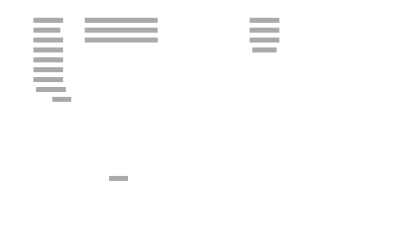

In [27]:
fig, axarr = plt.subplots(figsize=(7, 4), nrows=2, ncols=1)

# human ax
ax = axarr[0]

# plot motif locations
xs = list(range(0, 144))
prev_plotted = {}

# iterate through things plotted at each prev_y value
# if any overlaps, move
linewidth=5
for i, pos in enumerate(hu_motif_pos):
    #print("")
    #print("i: %s, pos: %s" % (i, pos))
    plotted = False
    if i == 0:
        #print("first motif, plotting at y=0")
        ax.plot([pos[0], pos[1]], [0, 0], color="darkgrey", linewidth=linewidth, solid_capstyle="butt")
        plotted = True
        prev_plotted[0] = [pos]
        continue
    for prev_y in sorted(prev_plotted.keys(), reverse=True):
        vals = prev_plotted[prev_y]
        overlaps = []
        for prev_pos in vals:
            overlaps.append(getOverlap(prev_pos, pos))
        if any(x < 0 for x in overlaps):
            #print("motif overlaps w/ %s, continuing" % (prev_y))
            continue
        else:
            if not plotted:
                #print("motif doesn't overlap anything at y=%s, plotting" % prev_y)
                ax.plot([pos[0], pos[1]], [prev_y, prev_y], color="darkgrey", linewidth=linewidth, 
                              solid_capstyle="butt")
                if prev_y not in prev_plotted:
                    prev_plotted[prev_y] = [pos]
                else:
                    new_vals = list(prev_plotted[prev_y])
                    new_vals.extend([pos])
                    prev_plotted[prev_y] = new_vals
                plotted = True
    if not plotted:
        prev_y -= 0.25
        #print("motif overlaps at all prev_y, plotting at %s" % prev_y)
        ax.plot([pos[0], pos[1]], [prev_y, prev_y], color="darkgrey", linewidth=linewidth, 
                      solid_capstyle="butt")
        if prev_y not in prev_plotted:
            prev_plotted[prev_y] = [pos]
        else:
            new_vals = list(prev_plotted[prev_y])
            new_vals.extend([pos])
            prev_plotted[prev_y] = new_vals
        plotted = True
#     print(prev_plotted)

min_y = np.min(list(prev_plotted.keys()))

# labels
ax.set_xlim((-0.5, 144))
ax.set_ylim((min_y - 0.25, 0.25))
ax.set_xlabel("nucleotide number")
ax.set_ylabel("")
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.axis("off")



# mouse ax
ax = axarr[1]

# plot motif locations
xs = list(range(0, 144))
prev_plotted = {}

# iterate through things plotted at each prev_y value
# if any overlaps, move
linewidth=5
for i, pos in enumerate(mo_motif_pos):
    #print("")
    #print("i: %s, pos: %s" % (i, pos))
    plotted = False
    if i == 0:
        #print("first motif, plotting at y=0")
        ax.plot([pos[0], pos[1]], [0, 0], color="darkgrey", linewidth=linewidth, solid_capstyle="butt")
        plotted = True
        prev_plotted[0] = [pos]
        continue
    for prev_y in sorted(prev_plotted.keys(), reverse=True):
        vals = prev_plotted[prev_y]
        overlaps = []
        for prev_pos in vals:
            overlaps.append(getOverlap(prev_pos, pos))
        if any(x < 0 for x in overlaps):
            #print("motif overlaps w/ %s, continuing" % (prev_y))
            continue
        else:
            if not plotted:
                #print("motif doesn't overlap anything at y=%s, plotting" % prev_y)
                ax.plot([pos[0], pos[1]], [prev_y, prev_y], color="darkgrey", linewidth=linewidth, 
                              solid_capstyle="butt")
                if prev_y not in prev_plotted:
                    prev_plotted[prev_y] = [pos]
                else:
                    new_vals = list(prev_plotted[prev_y])
                    new_vals.extend([pos])
                    prev_plotted[prev_y] = new_vals
                plotted = True
    if not plotted:
        prev_y -= 0.25
        #print("motif overlaps at all prev_y, plotting at %s" % prev_y)
        ax.plot([pos[0], pos[1]], [prev_y, prev_y], color="darkgrey", linewidth=linewidth, 
                      solid_capstyle="butt")
        if prev_y not in prev_plotted:
            prev_plotted[prev_y] = [pos]
        else:
            new_vals = list(prev_plotted[prev_y])
            new_vals.extend([pos])
            prev_plotted[prev_y] = new_vals
        plotted = True
#     print(prev_plotted)

min_y = np.min(list(prev_plotted.keys()))

# labels
ax.set_xlim((-0.5, 144))
ax.set_ylim((min_y - 0.25, 0.25))
ax.set_xlabel("nucleotide number")
ax.set_ylabel("")
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.axis("off")
    
plt.show()

In [42]:
prev_plotted

{}